In [1]:
import os

import time

import numpy as np

import networkx as nx

import pandas as pd

import tensorflow as tf
import tensorflow_probability as tfp

2025-01-06 13:11:51.905801: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-06 13:11:51.936839: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-01-06 13:11:51.936868: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-01-06 13:11:51.936880: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-06 13:11:51.942958: I tensorflow/core/platform/cpu_feature_g

In [2]:
import matplotlib.pyplot as plt

# Set font properties for ticks
plt.rcParams['xtick.labelsize'] = 12  # Font size of x-axis tick labels
plt.rcParams['ytick.labelsize'] = 12  # Font size of y-axis tick labels

# Set font properties for labels
plt.rcParams['axes.labelsize'] = 15  # Font size of axis labels

# Set font properties for title
plt.rcParams['axes.titlesize'] = 17  # Font size of titlea


# Covariates simulation

In [21]:
os.chdir("Scripts/")
%run -i covariates.py
os.chdir("../")

In [22]:
N = 50000

seed_to_use = 42
tf.random.set_seed((seed_to_use))
np.random.seed((seed_to_use))

seed_individuals = tfp.random.split_seed( seed_to_use, n=5, salt='seed_synthetic_pop')

categorical_prob = tfp.distributions.Dirichlet(concentration=tf.ones(3)).sample(seed = seed_individuals[4])
covariates_df = pd.DataFrame({"x":tfp.distributions.Uniform(low = 0.0, high = 10.0).sample(N, seed = seed_individuals[0]), 
			   "y":tfp.distributions.Uniform(low = 0.0, high = 10.0).sample(N, seed = seed_individuals[1]),
			   "covariate0":tfp.distributions.Normal(loc = 2.0, scale = 5.0).sample(N, seed = seed_individuals[2]), 
			   "covariate1":tfp.distributions.Categorical(probs = categorical_prob).sample(N, seed = seed_individuals[3]),})

(array([8.49828115e-05, 1.39749544e-03, 1.05567537e-02, 3.98569431e-02,
        7.34912552e-02, 6.86519556e-02, 3.27419925e-02, 8.16307117e-03,
        1.03867904e-03, 8.02615442e-05]),
 array([-18.7840271 , -14.54787636, -10.31172657,  -6.07557583,
         -1.83942568,   2.3967247 ,   6.63287497,  10.86902523,
         15.10517597,  19.34132576,  23.5774765 ]),
 <BarContainer object of 10 artists>)

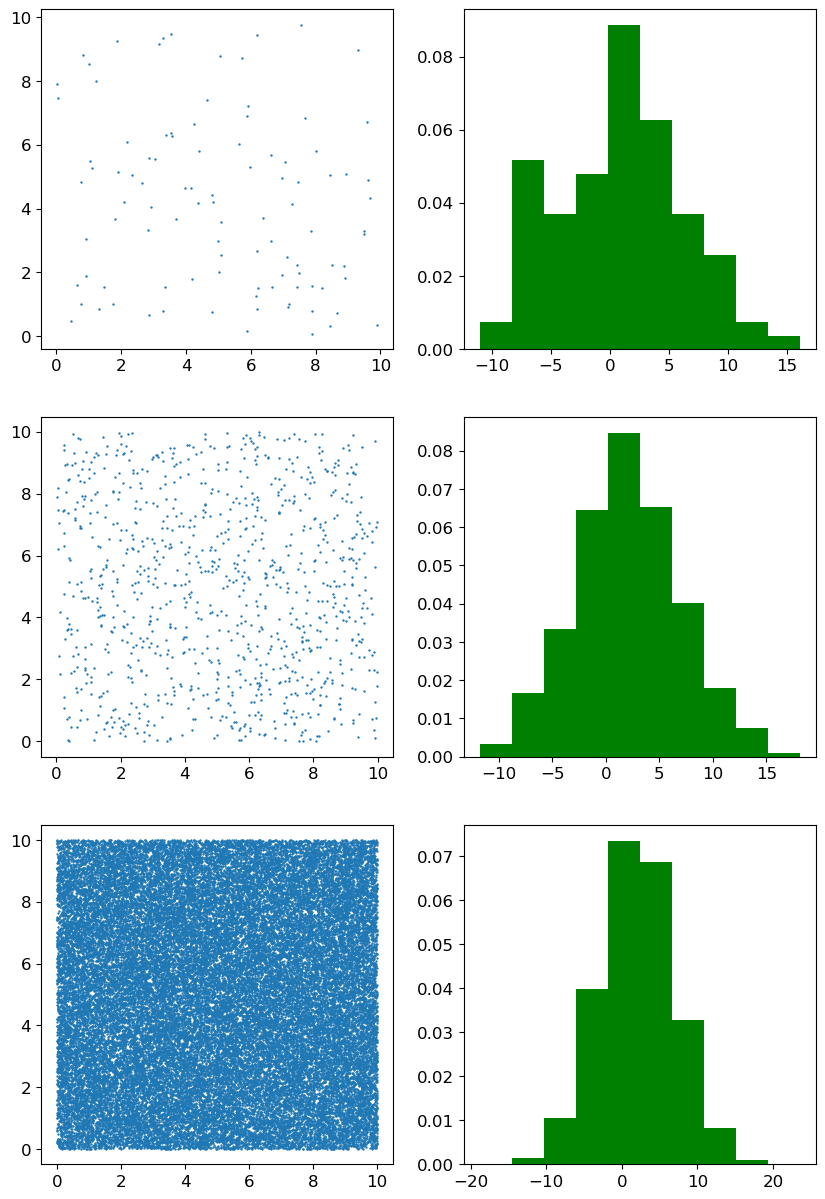

In [23]:
fig, ax = plt.subplots(3, 2, figsize = (10, 15))

pop = 100
ax[0,0].scatter(covariates_df[["x"]][:pop], covariates_df[["y"]][:pop], s = 0.5)
ax[0,1].hist(covariates_df[["covariate0"]][:pop], density = True, color = "green")

pop = 1000
ax[1,0].scatter(covariates_df[["x"]][:pop], covariates_df[["y"]][:pop], s = 0.5)
ax[1,1].hist(covariates_df[["covariate0"]][:pop], density = True, color = "green")

ax[2,0].scatter(covariates_df[["x"]][:], covariates_df[["y"]][:], s = 0.5)
ax[2,1].hist(covariates_df[["covariate0"]], density = True, color = "green")

We can normalize the covariates

In [24]:
covariates_df["covariate1"] = (covariates_df["covariate0"]-covariates_df["covariate0"].mean())/covariates_df["covariate0"].std()
covariates_df["covariate0"] = covariates_df["covariate0"]/covariates_df["covariate0"]


(array([0.00042434, 0.00697797, 0.05271199, 0.19901368, 0.36695651,
        0.34279293, 0.16348731, 0.04075985, 0.00518633, 0.00040076]),
 array([-4.16778564, -3.31940174, -2.47101784, -1.62263393, -0.77425003,
         0.07413387,  0.92251778,  1.77090168,  2.61928558,  3.46766949,
         4.31605339]),
 <BarContainer object of 10 artists>)

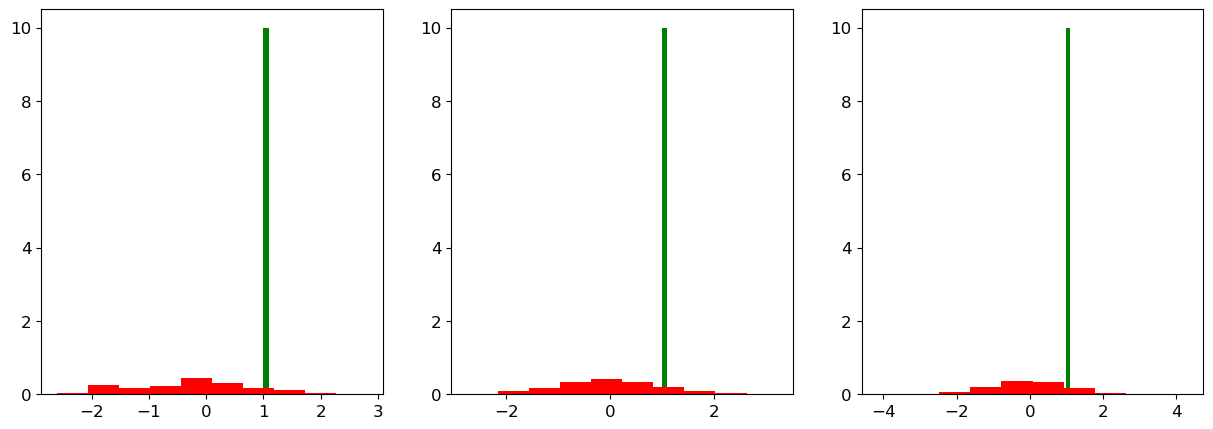

In [25]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

pop = 100
ax[0].hist(covariates_df[["covariate0"]][:pop], density = True, color = "green")
ax[0].hist(covariates_df[["covariate1"]][:pop], density = True, color = "red")

pop = 1000
ax[1].hist(covariates_df[["covariate0"]][:pop], density = True, color = "green")
ax[1].hist(covariates_df[["covariate1"]][:pop], density = True, color = "red")

ax[2].hist(covariates_df[["covariate0"]], density = True, color = "green")
ax[2].hist(covariates_df[["covariate1"]], density = True, color = "red")

In [26]:
locations  = tf.stack((covariates_df["x"], covariates_df["y"]), axis =1)
covariates = tf.stack((covariates_df["covariate0"], 
                       covariates_df["covariate1"]), axis =1)

# Simple SIS

In [27]:
os.chdir("Scripts/")
%run -i model.py
os.chdir("../")

In [28]:
N_pop = 1000
covariates = covariates[:N_pop,:]
locations  = locations[:N_pop,:]

N = tf.shape(covariates)[0]

parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
              "beta_l":tf.convert_to_tensor([-1.0, +2.0], dtype = tf.float32),
              "beta_g":tf.convert_to_tensor([-1.0, -1.0], dtype = tf.float32),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.5], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.5], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.1, 0.2], dtype = tf.float32)),}

SIS = basic_SIS(covariates)

2.13059139251709


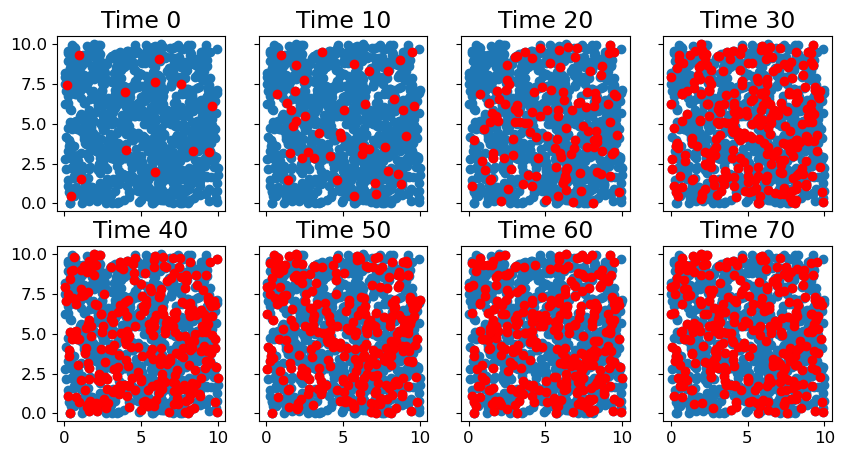

In [29]:
T    = 200
start = time.time()
X, Y = simulator(SIS, parameters, T)
print(time.time()-start)

fig, ax = plt.subplots(2, 4, figsize = (10, 5), sharex=True, sharey=True)

for i in range(2):
    for j in range(4):

        t = 10*(i*4+j)

        infected = tf.where(X[t,0,:,1]==1)[:,0]

        ax[i, j].set_title("Time "+str(t))
        ax[i, j].scatter(locations[:,0], locations[:,1])
        ax[i, j].scatter(tf.gather(locations[:,0], infected),
                         tf.gather(locations[:,1], infected), color = "red")

In [30]:
os.chdir("Scripts/")
%run -i CAL.py
%run -i CAL_without_correction.py
os.chdir("../")

In [31]:
T = 200
start = time.time()
X, Y = simulator(SIS, parameters, T)
print(time.time()-start)

X, Y = X[:,0,...], Y[:,0,...]

2.213045120239258


The time lap is  0.7131452560424805
The log-likelihood is  -93187.66


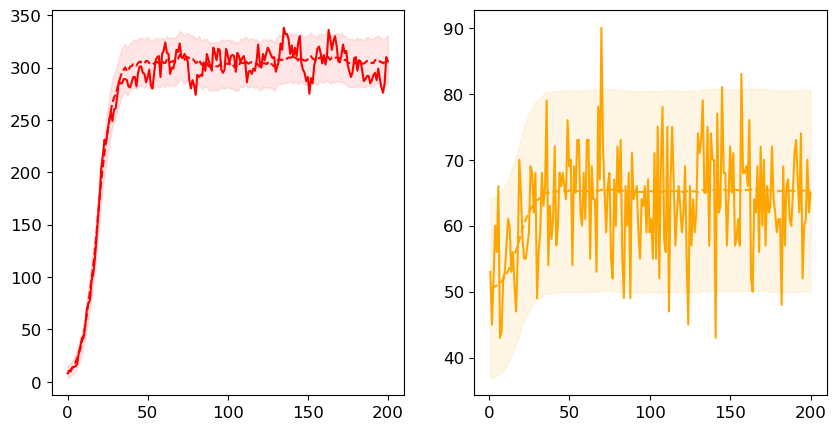

In [32]:
start = time.time()
Pi, Mu, log_likelihood = CAL(SIS, parameters, Y)
print("The time lap is ", time.time()-start)
print("The log-likelihood is ", log_likelihood.numpy())

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

population = tf.reduce_sum(X, axis = 1)
mean_Pi = tf.reduce_sum(Pi, axis = 1)
var_Pi  = tf.reduce_sum(Pi*(1-Pi), axis = 1)

obs_population = tf.reduce_sum(Y, axis = 1)
mean_Mu = tf.reduce_sum(Mu, axis = 1)
var_Mu  = tf.reduce_sum(Mu*(1-Mu), axis = 1)

time_steps = np.linspace(0, tf.shape(X)[0]-1, tf.shape(X)[0])

ax[0].plot(time_steps, population[...,1], color = "red")
ax[0].plot(time_steps, mean_Pi[...,1], color = "red", linestyle = "dashed")
ax[0].fill_between(time_steps, mean_Pi[...,1] - 1.96*tf.math.sqrt(var_Pi[...,1]), mean_Pi[...,1] + 1.96*tf.math.sqrt(var_Pi[...,1]), color = "red", alpha = 0.1)

ax[1].plot(time_steps[1:], obs_population[...,2], color = "orange")
ax[1].plot(time_steps[1:], mean_Mu[...,2], color = "orange", linestyle = "dashed")
ax[1].fill_between(time_steps[1:], mean_Mu[...,2] - 1.96*tf.math.sqrt(var_Mu[...,2]), mean_Mu[...,2] + 1.96*tf.math.sqrt(var_Mu[...,2]), color = "orange", alpha = 0.1)

In [17]:
n_gradient_steps = 1000

par_to_upd = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.1, 0.2], dtype = tf.float32)),}

learning_parameters = {"beta_l":2, "beta_g":2, "logit_sensitivity":1, "logit_specificity":1 }
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.5)

loss_tensor, parameters_tensor = CAL_inference(SIS, par_to_upd, Y, learning_parameters, optimizer, n_gradient_steps)

2025-01-06 13:14:20.687527: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x27a7f850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-01-06 13:14:20.687567: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2025-01-06 13:14:20.780836: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-01-06 13:14:21.365560: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2025-01-06 13:14:22.006169: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_48', 176 bytes spill stores, 176 bytes spill loads

2025-01-06 13:14:22.160160: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is 

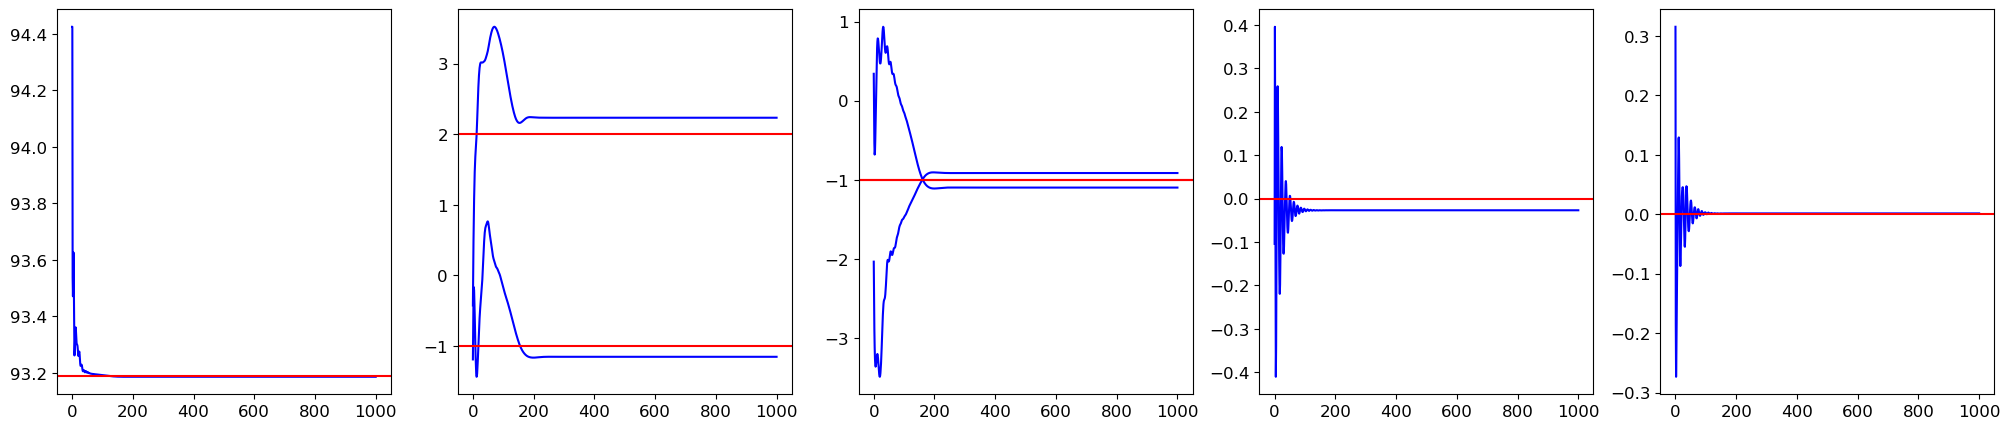

In [18]:
fig, ax = plt.subplots(1, len(learning_parameters)+1, figsize = ((len(learning_parameters)+1)*5, 5))

ax[0].plot(loss_tensor, color = "blue")
ax[0].axhline(CAL_loss(SIS, parameters, Y), color = "red")

counter = 0
for key in learning_parameters.keys():
    # print(key)
    for i in range(learning_parameters[key]):
        # print(i)
        ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
        ax[counter+1].axhline(parameters[key][i], color = "red")
    
    counter = counter +1

# Spatial SIS

In [33]:
os.chdir("Scripts/")
%run -i model.py
%run -i CAL.py
os.chdir("../")

In [51]:
seed_to_use = 42

tf.random.set_seed((seed_to_use))
np.random.seed((seed_to_use))

seed_individuals = tfp.random.split_seed( seed_to_use, n=5, salt='seed_synthetic_pop')
seed_carry       = seed_individuals[4]

n_cities = 10

cities_std = tfp.distributions.Gamma(concentration = 10, rate = 12).sample((n_cities, 2), seed = seed_individuals[0])

centroids = tfp.distributions.Uniform(low = [0.0, 0.0], high = [10.0, 10.0]).sample(n_cities, seed = seed_individuals[1])

nr_individuals_per_city = 100

covariates_rv_list = [tfp.distributions.Normal(loc = 0.0, scale = 1.0)]

covariates_df = make_covariates(n_cities, nr_individuals_per_city, cities_std, centroids, covariates_rv_list, seed_individuals[2])

In [57]:
locations  = tf.stack((covariates_df["x"], covariates_df["y"]), axis =1)
covariates = tf.stack((tf.ones(tf.shape(covariates_df["covariate0"])), 
                       covariates_df["covariate0"]), axis =1)

In [60]:
N_pop = 1000
covariates = tf.convert_to_tensor(covariates, dtype = tf.float32)[:N_pop,:]
locations  = tf.convert_to_tensor(locations, dtype = tf.float32)[:N_pop,:]
# locations  = (locations - tf.reduce_mean(locations, axis = 0, keepdims=True))/tf.math.reduce_std(locations, axis = 0, keepdims=True)

N = tf.shape(locations)[0]
parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
              "beta_l":tf.convert_to_tensor([-2.0, +2.0], dtype = tf.float32),
              "beta_g":tf.convert_to_tensor([-1.0, -1.0], dtype = tf.float32),
              "log_phi":tf.math.log(
                tf.convert_to_tensor([2.0], dtype = tf.float32)),
              "log_chi":tf.math.log(
                tf.convert_to_tensor([50.0], dtype = tf.float32)),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.2, 0.5], dtype = tf.float32)),
		"log_epsilon":tf.math.log(tf.convert_to_tensor([0.001], dtype = tf.float32)),}

SIS = spatial_SIS(locations, covariates)


1.5779402256011963


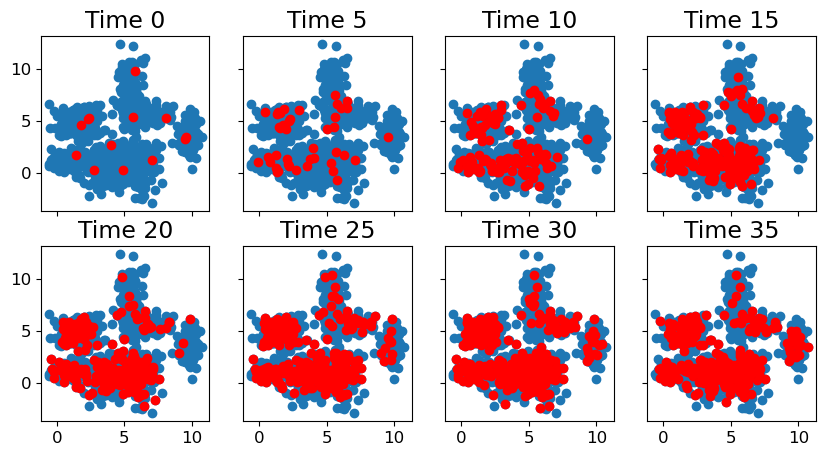

In [61]:
T    = 100
start = time.time()
X, Y = simulator(SIS, parameters, T)
print(time.time()-start)

fig, ax = plt.subplots(2, 4, figsize = (10, 5), sharex=True, sharey=True)

for i in range(2):
    for j in range(4):

        t = 5*(i*4+j)

        infected = tf.where(X[t,0,:,1]==1)[:,0]

        ax[i, j].set_title("Time "+str(t))
        ax[i, j].scatter(locations[:,0], locations[:,1])
        ax[i, j].scatter(tf.gather(locations[:,0], infected),
                         tf.gather(locations[:,1], infected), color = "red")

The time lap is  0.7901372909545898
The log-likelihood is  -70317.3


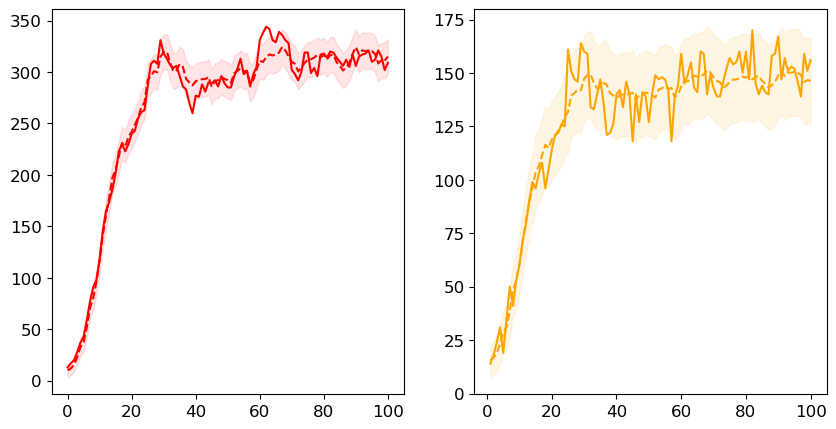

In [62]:
# T = 200
# start = time.time()
# X, Y = simulator(SIS, parameters, T)
# print(time.time()-start)

X, Y = X[:,0,...], Y[:,0,...]

start = time.time()
Pi, Mu, log_likelihood_wrong = CAL(SIS, parameters, Y)
print("The time lap is ", time.time()-start)
print("The log-likelihood is ", log_likelihood_wrong.numpy())

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

population = tf.reduce_sum(X, axis = 1)
mean_Pi = tf.reduce_sum(Pi, axis = 1)
var_Pi  = tf.reduce_sum(Pi*(1-Pi), axis = 1)

obs_population = tf.reduce_sum(Y, axis = 1)
mean_Mu = tf.reduce_sum(Mu, axis = 1)
var_Mu  = tf.reduce_sum(Mu*(1-Mu), axis = 1)

time_steps = np.linspace(0, tf.shape(X)[0]-1, tf.shape(X)[0])

ax[0].plot(time_steps, population[...,1], color = "red")
ax[0].plot(time_steps, mean_Pi[...,1], color = "red", linestyle = "dashed")
ax[0].fill_between(time_steps, mean_Pi[...,1] - 1.96*tf.math.sqrt(var_Pi[...,1]), mean_Pi[...,1] + 1.96*tf.math.sqrt(var_Pi[...,1]), color = "red", alpha = 0.1)

ax[1].plot(time_steps[1:], obs_population[...,2], color = "orange")
ax[1].plot(time_steps[1:], mean_Mu[...,2], color = "orange", linestyle = "dashed")
ax[1].fill_between(time_steps[1:], mean_Mu[...,2] - 1.96*tf.math.sqrt(var_Mu[...,2]), mean_Mu[...,2] + 1.96*tf.math.sqrt(var_Mu[...,2]), color = "orange", alpha = 0.1)

In [63]:
n_gradient_steps = 500

par_to_upd = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.2, 0.5], dtype = tf.float32)),
		"log_epsilon":tf.math.log(tf.convert_to_tensor([0.001], dtype = tf.float32)),}

learning_parameters = {"beta_l":2, "beta_g":2, "log_phi":1, "log_chi":1}
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.5)

loss_tensor, parameters_tensor = CAL_inference(SIS, par_to_upd, Y, learning_parameters, optimizer, n_gradient_steps)

2025-01-06 13:20:38.699518: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_58', 128 bytes spill stores, 128 bytes spill loads



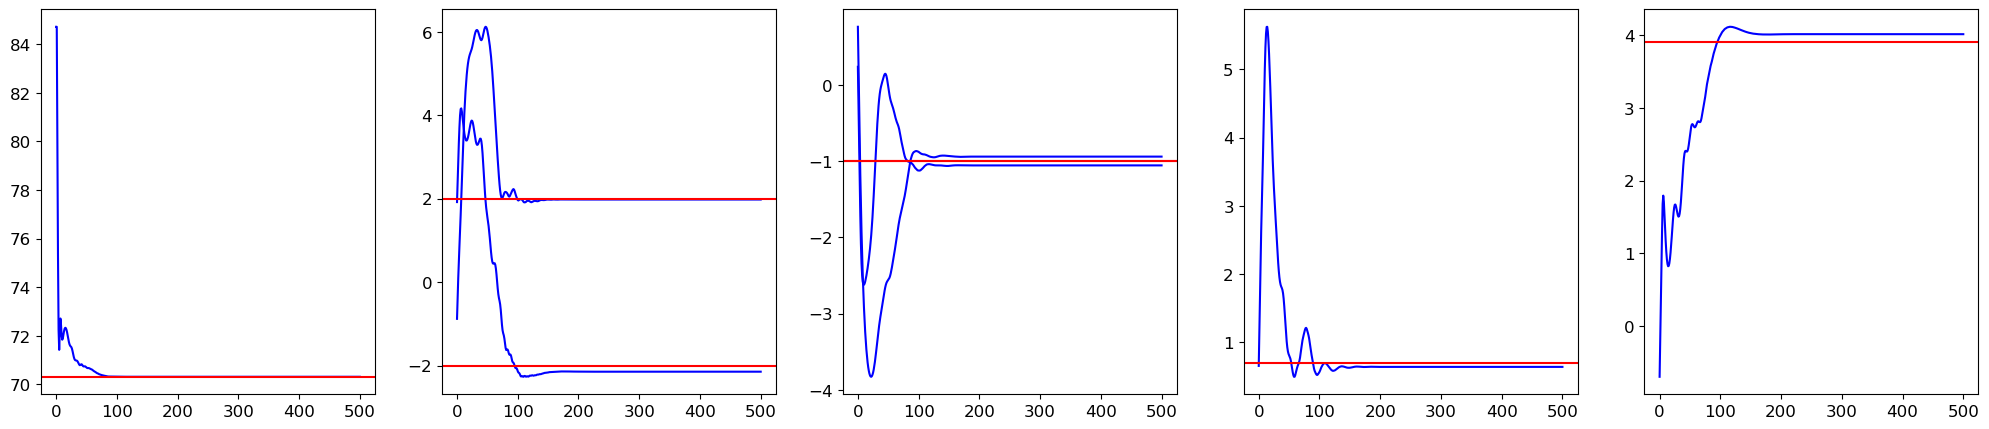

In [64]:
fig, ax = plt.subplots(1, len(learning_parameters)+1, figsize = ((len(learning_parameters)+1)*5, 5))

ax[0].plot(loss_tensor, color = "blue")
ax[0].axhline(CAL_loss(SIS, parameters, Y), color = "red")

counter = 0
for key in learning_parameters.keys():
	# print(key)
	for i in range(learning_parameters[key]):
		# print(i)
		ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
		ax[counter+1].axhline(parameters[key][i], color = "red")

	counter = counter +1

# Stochastic block model SIS

In [67]:
import networkx as nx

In [68]:
Ncommunities = 5

B = 0.95*tf.eye(Ncommunities)
sovra_diag       = tf.concat((tf.concat((tf.zeros((Ncommunities-1, 1)), tf.eye(Ncommunities-1)), axis = 1), tf.zeros((1, Ncommunities))), axis = 0)
sovra_sovra_diag = tf.concat((tf.concat((tf.zeros((Ncommunities-1, 1)), sovra_diag[:-1,:-1]), axis = 1), tf.zeros((1, Ncommunities))), axis = 0)
sovra_sovra_sovra_diag = tf.concat((tf.concat((tf.zeros((Ncommunities-1, 1)), sovra_sovra_diag[:-1,:-1]), axis = 1), tf.zeros((1, Ncommunities))), axis = 0)
B = tf.experimental.numpy.triu(B + 0.25*sovra_diag + 0.125*sovra_sovra_diag + 0.05*sovra_sovra_sovra_diag)
B = B + tf.transpose(tf.experimental.numpy.triu(B, k = 1))

N = 50000
initial_distribution = tfp.distributions.Dirichlet(np.abs(np.random.normal(10, 5, Ncommunities))).sample()

communities = tfp.distributions.Categorical(probs = initial_distribution).sample(N)
communities = tf.one_hot(communities, Ncommunities)

In [71]:
N_pop = 1000
communities = tf.convert_to_tensor(communities, dtype = tf.float32)[:N_pop,:]

In [72]:
os.chdir("Scripts/")
%run -i model.py
# %run -i CAL_without_correction.py
%run -i CAL.py
os.chdir("../")

In [79]:
N = tf.shape(covariates)[0]
parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
              "beta_l":tf.convert_to_tensor([-1.0, +2.0], dtype = tf.float32),
              "beta_g":tf.convert_to_tensor([-1.0, -1.0], dtype = tf.float32),
        #       "logit_B":logit(B),
	      "log_graph":tf.math.log(tf.convert_to_tensor([0.1], dtype = tf.float32)),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.2, 0.5], dtype = tf.float32)),
              "log_epsilon":tf.math.log(
                tf.convert_to_tensor([0.001], dtype = tf.float32)),}

SIS = sbm_SIS(communities, covariates)

B = SIS.B_matrix(parameters)
nodes = range(B.shape[0])
G = nx.Graph()
for i in nodes:
    for j in nodes:
        if i > j and B.numpy()[i, j]!=0:
            G.add_edge(i, j, weight=10*B.numpy()[i, j])

1.769536018371582


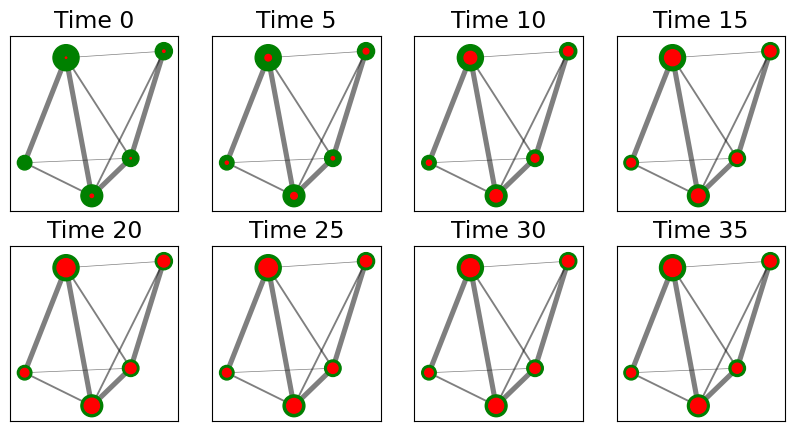

In [80]:
T    = 100
start = time.time()
X, Y = simulator(SIS, parameters, T)
print(time.time()-start)

X, Y = X[:,0,...], Y[:,0,...]

population = tf.reduce_sum(X, axis = 1)

fig, ax = plt.subplots(2, 4, figsize = (10, 5), sharex=True, sharey=True)

for i in range(2):
	for j in range(4):

		t = 5*(i*4+j)

		ax[i, j].set_title("Time "+str(t))
		
		current_state = tf.einsum("tns,nc->tcs", X, SIS.communities)[t,...]
		percentage    = current_state/tf.reduce_sum(current_state, axis = 1, keepdims=True)

		pos = nx.spring_layout(G, seed = 10)  # Positions for all nodes
		weight_labels = nx.get_edge_attributes(G, 'weight')

		color_map = ["green" for node in G.nodes] 
		nx.draw_networkx_nodes( G, pos, 
					node_color = color_map, node_shape='o', node_size = tf.reduce_sum(SIS.communities, axis = 0),
					ax = ax[i,j])

		color_map = ["red" for node in G.nodes] 
		nx.draw_networkx_nodes( G, pos, 
			 		node_color=color_map, node_shape='o', node_size = tf.reduce_sum(SIS.communities, axis = 0)*percentage[:,1],
					ax = ax[i,j])
		
		nx.draw_networkx_edges( G, pos, 
			 		edgelist = weight_labels.keys(), width=list(weight_labels.values()), edge_color='black', alpha=0.5,
					ax = ax[i,j])

1.8020834922790527
The time lap is  0.9796721935272217
The log-likelihood is  -76625.664


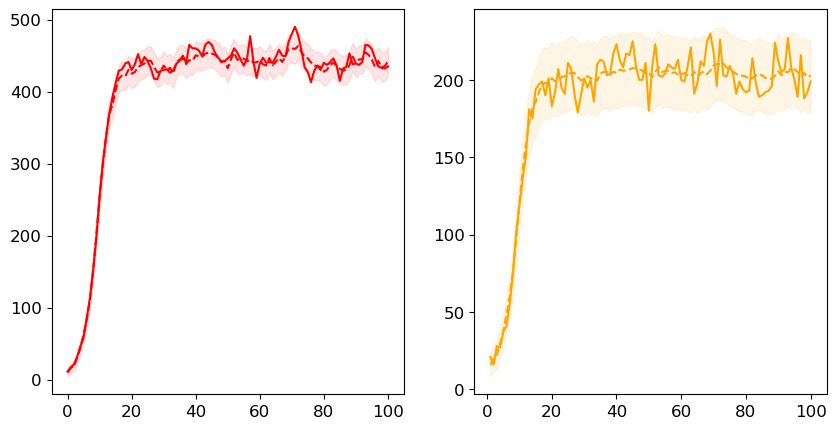

In [81]:
T = 100
start = time.time()
X, Y = simulator(SIS, parameters, T)
print(time.time()-start)

X, Y = X[:,0,...], Y[:,0,...]

start = time.time()
Pi, Mu, log_likelihood = CAL(SIS, parameters, Y)
print("The time lap is ", time.time()-start)
print("The log-likelihood is ", log_likelihood.numpy())

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

population = tf.reduce_sum(X, axis = 1)
mean_Pi = tf.reduce_sum(Pi, axis = 1)
var_Pi  = tf.reduce_sum(Pi*(1-Pi), axis = 1)

obs_population = tf.reduce_sum(Y, axis = 1)
mean_Mu = tf.reduce_sum(Mu, axis = 1)
var_Mu  = tf.reduce_sum(Mu*(1-Mu), axis = 1)

time_steps = np.linspace(0, tf.shape(X)[0]-1, tf.shape(X)[0])

ax[0].plot(time_steps, population[...,1], color = "red")
ax[0].plot(time_steps, mean_Pi[...,1], color = "red", linestyle = "dashed")
ax[0].fill_between(time_steps, mean_Pi[...,1] - 1.96*tf.math.sqrt(var_Pi[...,1]), mean_Pi[...,1] + 1.96*tf.math.sqrt(var_Pi[...,1]), color = "red", alpha = 0.1)

ax[1].plot(time_steps[1:], obs_population[...,2], color = "orange")
ax[1].plot(time_steps[1:], mean_Mu[...,2], color = "orange", linestyle = "dashed")
ax[1].fill_between(time_steps[1:], mean_Mu[...,2] - 1.96*tf.math.sqrt(var_Mu[...,2]), mean_Mu[...,2] + 1.96*tf.math.sqrt(var_Mu[...,2]), color = "orange", alpha = 0.1)

In [85]:
n_gradient_steps = 500

par_to_upd = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01], dtype = tf.float32),
              "log_graph":tf.math.log(tf.convert_to_tensor([0.1], dtype = tf.float32)),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "log_epsilon":tf.math.log(
                tf.convert_to_tensor([0.001], dtype = tf.float32)),}

learning_parameters = {"beta_l":2, "beta_g":2, "logit_prob_testing":2}
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.5)

loss_tensor, parameters_tensor = CAL_without_correction_inference(SIS, par_to_upd, Y, learning_parameters, optimizer, n_gradient_steps)

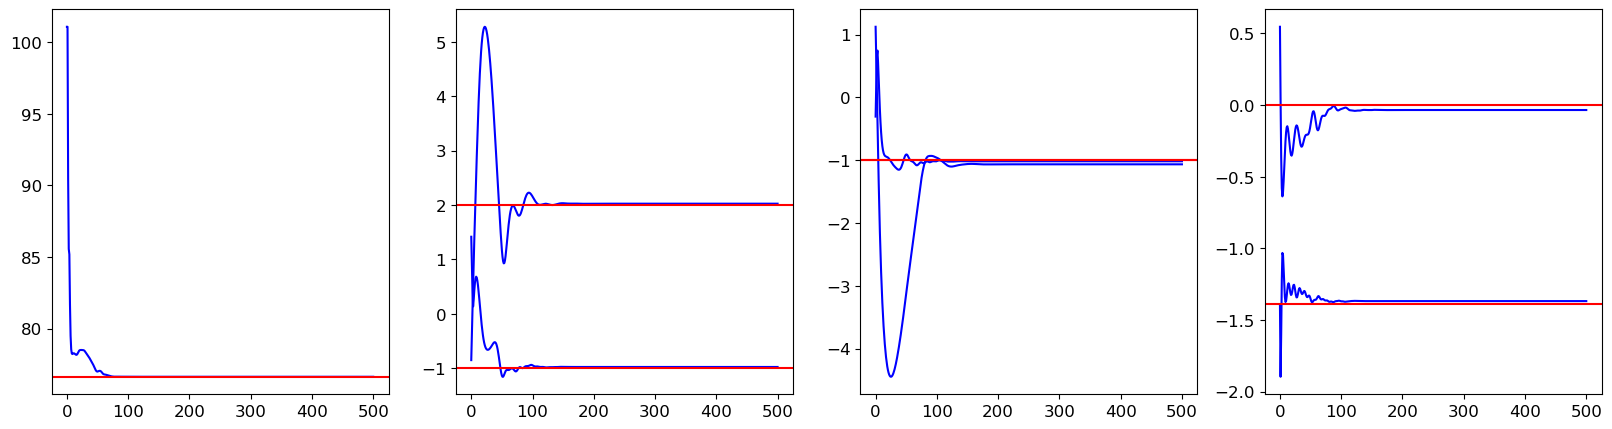

In [88]:
fig, ax = plt.subplots(1, len(learning_parameters)+1, figsize = ((len(learning_parameters)+1)*5, 5))

ax[0].plot(loss_tensor, color = "blue")
ax[0].axhline(CAL_loss(SIS, parameters, Y), color = "red")

counter = 0
for key in learning_parameters.keys():
	# print(key)
	for i in range(learning_parameters[key]):
		# print(i)
		ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
		ax[counter+1].axhline(parameters[key][i], color = "red")

	counter = counter +1

In [89]:
n_gradient_steps = 400

par_to_upd = {"prior_infection":tf.convert_to_tensor([1-0.005, 0.005], dtype = tf.float32),
              "logit_sensitivity":logit(
                tf.convert_to_tensor([0.9], dtype = tf.float32)),
              "logit_specificity":logit(
                tf.convert_to_tensor([0.95], dtype = tf.float32)),
              "log_epsilon":tf.math.log(
                tf.convert_to_tensor([0.001], dtype = tf.float32)),}

learning_parameters = {"beta_l":2, "beta_g":2, "logit_prob_testing":2, "log_graph":1}
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.5)

loss_tensor, parameters_tensor = CAL_inference(SIS, par_to_upd, Y, learning_parameters, optimizer, n_gradient_steps)

2025-01-06 13:27:20.410581: I tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:328] ptxas warning : Registers are spilled to local memory in function 'fusion_63', 224 bytes spill stores, 224 bytes spill loads



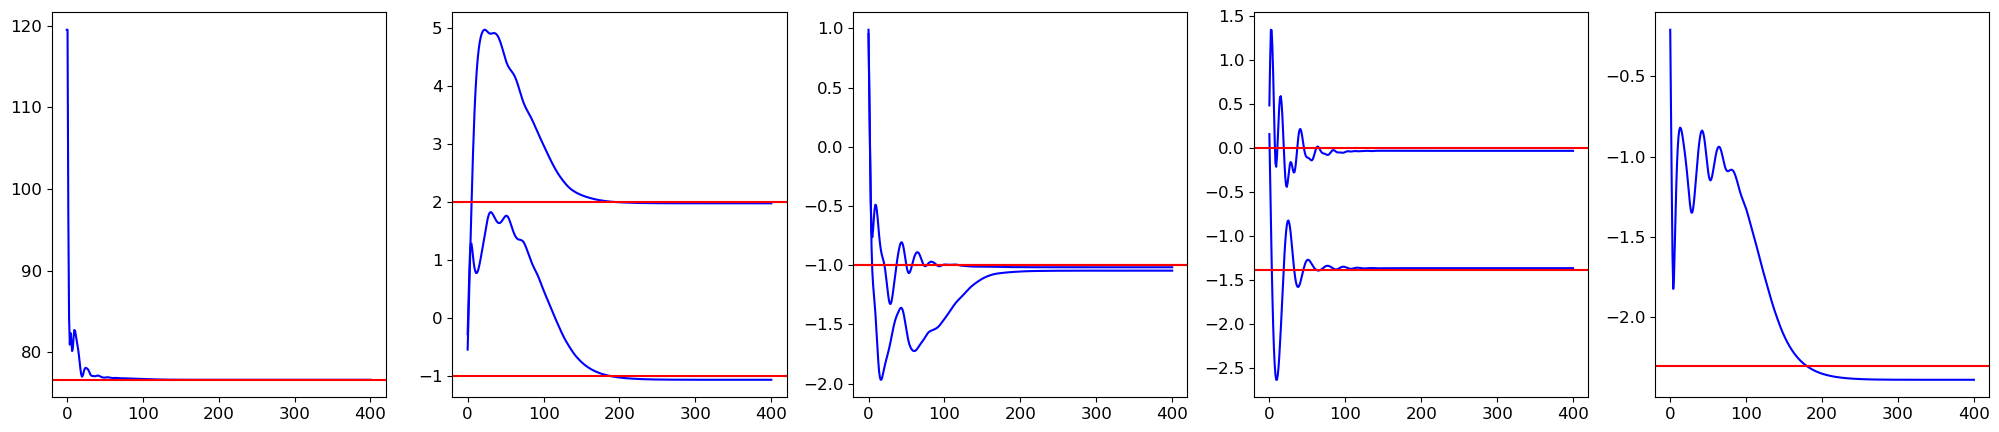

In [90]:
fig, ax = plt.subplots(1, len(learning_parameters)+1, figsize = ((len(learning_parameters)+1)*5, 5))

ax[0].plot(loss_tensor, color = "blue")
ax[0].axhline(CAL_loss(SIS, parameters, Y), color = "red")

counter = 0
for key in learning_parameters.keys():
	# print(key)
	for i in range(learning_parameters[key]):
		# print(i)
		ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
		ax[counter+1].axhline(parameters[key][i], color = "red")

	counter = counter +1

# Network SIR

In [91]:
os.chdir("Scripts/")
%run -i model.py
os.chdir("../")

In [95]:
N_pop = 1000

G = nx.watts_strogatz_graph(n = N_pop, k = 6, p = 0.1)
connection_matrix = tf.convert_to_tensor(nx.adjacency_matrix(G).todense(), dtype = tf.float32)

SIR = network_SIR(connection_matrix, covariates)

In [96]:
parameters = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01, 0.0], dtype = tf.float32),
              "beta_l":tf.convert_to_tensor([1.0, 2.0], dtype = tf.float32),
              "beta_g":tf.convert_to_tensor([-1.0, -1.0], dtype = tf.float32),
              "logit_prob_testing":logit(
                tf.convert_to_tensor([0.5, 0.5, 0.5], dtype = tf.float32)),}

2.9341228008270264


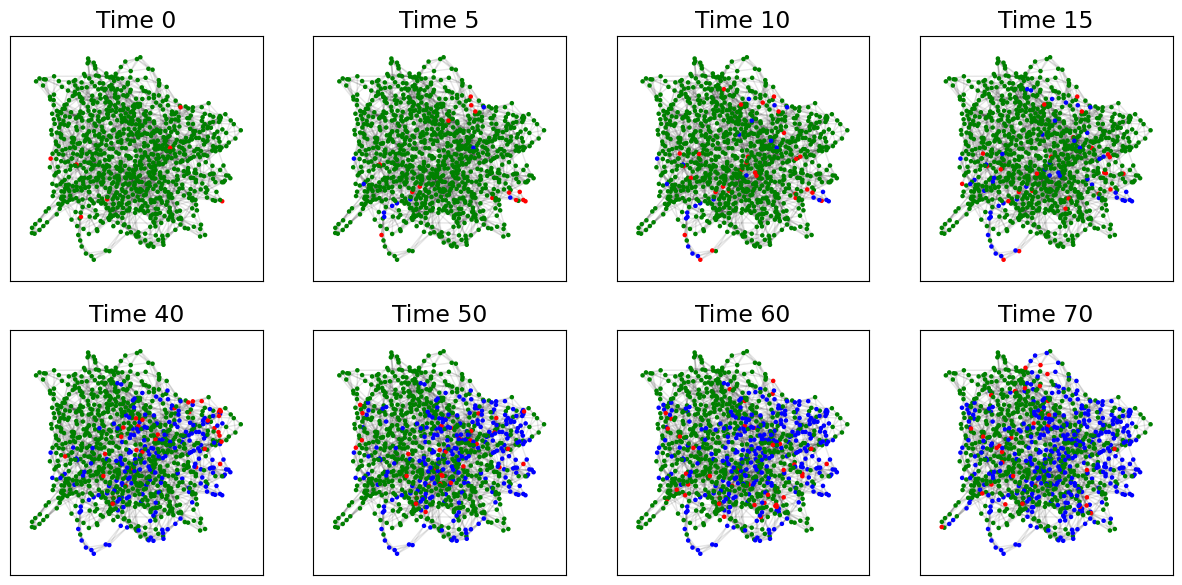

In [97]:
T    = 200
start = time.time()
X, Y = simulator(SIR, parameters, T)
print(time.time()-start)

X, Y = X[:,0,...], Y[:,0,...]

fig, ax = plt.subplots(2, 4, figsize = (15, 7), sharex=True, sharey=True)

pos = nx.spring_layout(G, seed = 10)

jump_list = [5, 10]
for i in range(2):
	for j in range(4):  

		t = jump_list[i]*(i*4+j)

		ax[i, j].set_title("Time "+str(t))

		color_map = np.where(X[t, :, 1]==1, 'red', 'green')
		color_map = np.where(X[t, :, 2]==1, "blue", color_map)

		nx.draw_networkx_nodes( G, pos, node_color = color_map, node_shape='o', node_size = 5000/N_pop,
			 ax = ax[i,j])
		nx.draw_networkx_edges( G, pos, alpha=0.1,
			 ax = ax[i,j])

In [98]:
os.chdir("Scripts/")
%run -i CAL.py
os.chdir("../")

The time lap is  0.8733856678009033
The log-likelihood is  -140412.56


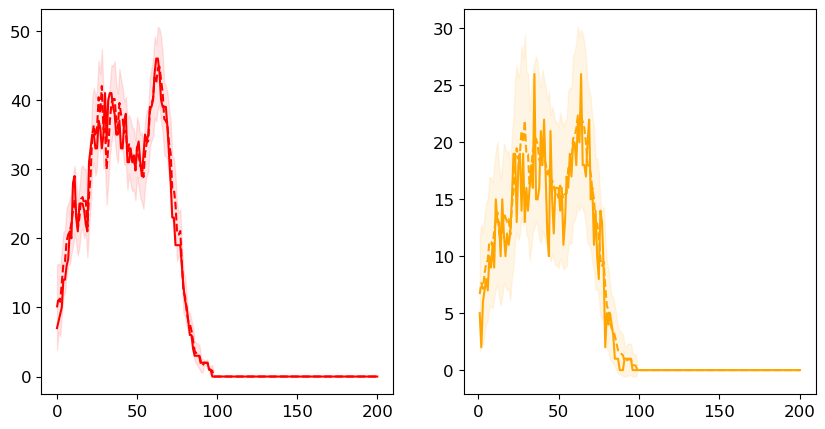

In [99]:
start = time.time()
Pi, Mu, log_likelihood = CAL(SIR, parameters, Y)
print("The time lap is ", time.time()-start)
print("The log-likelihood is ", log_likelihood.numpy())

fig, ax = plt.subplots(1, 2, figsize = (10, 5))

population = tf.reduce_sum(X, axis = 1)
mean_Pi = tf.reduce_sum(Pi, axis = 1)
var_Pi  = tf.reduce_sum(Pi*(1-Pi), axis = 1)

obs_population = tf.reduce_sum(Y, axis = 1)
mean_Mu = tf.reduce_sum(Mu, axis = 1)
var_Mu  = tf.reduce_sum(Mu*(1-Mu), axis = 1)

time_steps = np.linspace(0, tf.shape(X)[0]-1, tf.shape(X)[0])

ax[0].plot(time_steps, population[...,1], color = "red")
ax[0].plot(time_steps, mean_Pi[...,1], color = "red", linestyle = "dashed")
ax[0].fill_between(time_steps, mean_Pi[...,1] - 1.96*tf.math.sqrt(var_Pi[...,1]), mean_Pi[...,1] + 1.96*tf.math.sqrt(var_Pi[...,1]), color = "red", alpha = 0.1)

ax[1].plot(time_steps[1:], obs_population[...,2], color = "orange")
ax[1].plot(time_steps[1:], mean_Mu[...,2], color = "orange", linestyle = "dashed")
ax[1].fill_between(time_steps[1:], mean_Mu[...,2] - 1.96*tf.math.sqrt(var_Mu[...,2]), mean_Mu[...,2] + 1.96*tf.math.sqrt(var_Mu[...,2]), color = "orange", alpha = 0.1)

In [102]:
n_gradient_steps = 400

par_to_upd = {"prior_infection":tf.convert_to_tensor([1-0.01, 0.01, 0.0], dtype = tf.float32),}

learning_parameters = {"beta_l":2, "beta_g":2, "logit_prob_testing":3}
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.5)

loss_tensor, parameters_tensor = CAL_inference(SIR, par_to_upd, Y, learning_parameters, optimizer, n_gradient_steps)

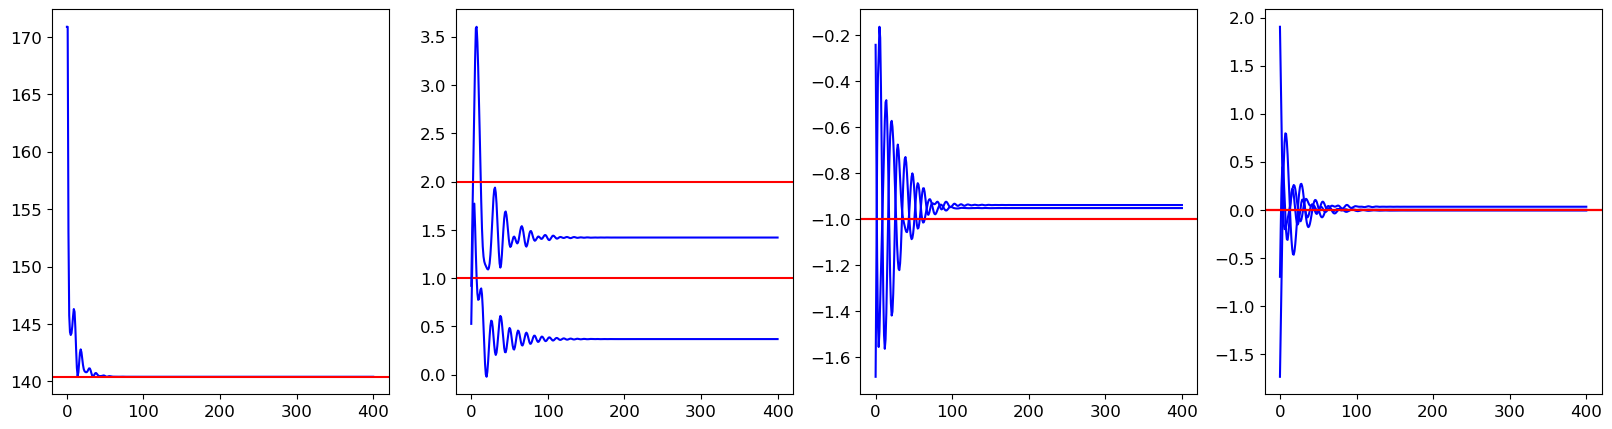

In [103]:
fig, ax = plt.subplots(1, len(learning_parameters)+1, figsize = ((len(learning_parameters)+1)*5, 5))

ax[0].plot(loss_tensor, color = "blue")
ax[0].axhline(CAL_loss(SIR, parameters, Y), color = "red")

counter = 0
for key in learning_parameters.keys():
	# print(key)
	for i in range(learning_parameters[key]):
		# print(i)
		ax[counter+1].plot(parameters_tensor[key][:, i], color = "blue")
		ax[counter+1].axhline(parameters[key][i], color = "red")

	counter = counter +1

a